<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/notebooks/languageXplay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install package dependencies (forces restart)
import os

def restart_runtime():
    print('Runtime restarting...')
    os.kill(os.getpid(), 9)
    
!git clone 'https://github.com/sholtodouglas/pandaRL' 'local_packages/pandaRL'
!pip install -e 'local_packages/pandaRL/.'

restart_runtime()

In [1]:
!pip -q install pybullet wandb

     |████████████████████████████████| 76.6MB 92kB/s 
     |████████████████████████████████| 1.9MB 61.3MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 163kB 60.0MB/s 
     |████████████████████████████████| 102kB 11.7MB/s 
     |████████████████████████████████| 133kB 60.5MB/s 
     |████████████████████████████████| 71kB 8.9MB/s 


In [2]:
#@title Workpace Setup (Local vs Colab)
from pathlib import Path
import os

COLAB = True #@param {type:"boolean"}
AUTH_GCS = False #@param {type:"boolean"}
DEVICE = "TPU" #@param ["TPU", "GPU", "CPU"]
DATA_SOURCE = "Google Drive" #@param ["Google Drive", "GCS"]
TEST_DATASET = "UR5_slow_gripper_test" #@param ["UR5_slow_gripper_test"]
GCS_USER = "sholto" #@param ["sholto", "tristan"]

if COLAB:
    from google.colab import drive, auth
    print('Using colab setup')
    !git clone 'https://github.com/sholtodouglas/learning_from_play'
    WORKING_PATH = Path('/content/learning_from_play')
    drive.mount('/content/drive')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
    print(f'Storage path: {STORAGE_PATH}')
    
    TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in ["UR5","UR5_slow_gripper","UR5_high_transition"]]
    TEST_DATA_PATH = STORAGE_PATH/'data'/TEST_DATASET

else:
    print('Using local setup')
    WORKING_PATH = Path().absolute().parent
    print(f'Working path: {WORKING_PATH}')
    os.chdir(WORKING_PATH)
    STORAGE_PATH = WORKING_PATH
    print(f'Storage path: {STORAGE_PATH}')
    
    TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in ["UR5", "UR5_high_transition", "UR5_slow_gripper"]]
    TEST_DATA_PATH = STORAGE_PATH/'data'/TEST_DATASET

Using colab setup
Cloning into 'learning_from_play'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (234/234), done.
remote: Total 1203 (delta 177), reused 115 (delta 53), pack-reused 916
Receiving objects: 100% (1203/1203), 52.41 MiB | 31.04 MiB/s, done.
Resolving deltas: 100% (592/592), done.
Mounted at /content/drive
Storage path: /content/drive/My Drive/Robotic Learning


# Data Creation

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

if DEVICE == "TPU":
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
else:
    physical_devices = tf.config.list_physical_devices()
    if DEVICE == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.4.1
Running on TPU  ['10.31.128.106:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.31.128.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.31.128.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Dataset

In [4]:
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import pickle
import os
from collections import Counter
import random
import datetime

import lfp
from natsort import natsorted

In [5]:
# Use this to edit modules without needing to restart the kernel
import importlib
importlib.reload(lfp.data)

<module 'lfp.data' from '/content/learning_from_play/lfp/data.py'>

### Config Flags

In [6]:
LAYER_SIZE = 2048
LATENT_DIM = LAYER_SIZE//8
GRIPPER_WEIGHT = 1.0
GCBC = False
PROBABILISTIC = False
INFO_VAE = False
QUANTISED = False
N_QUANTISATIONS = 256

In [7]:
BATCH_SIZE = 512
GLOBAL_BATCH_SIZE = BATCH_SIZE * NUM_DEVICES
dataloader = lfp.data.PlayDataloader(batch_size=BATCH_SIZE*NUM_DEVICES)

In [8]:
train_data = dataloader.extract(TRAIN_DATA_PATHS)
valid_data = dataloader.extract([TEST_DATA_PATH])

636298 frames, which is 7hrs 4m.
15396 frames, which is 0hrs 10m.


In [9]:
train_dataset = dataloader.load(train_data)
valid_dataset = dataloader.load(valid_data)

{'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None), 'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None), 'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None), 'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None), 'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None), 'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None), 'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None)}
{'obs': TensorSpec(shape=(4096, 50, 18), dtype=tf.float32, name=None), 'acts': TensorSpec(shape=(4096, 50, 7), dtype=tf.float32, name=None), 'goals': TensorSpec(shape=(4096, 50, 11), dtype=tf.float32, name=None), 'seq_lens': TensorSpec(shape=(4096,), dtype=tf.float32, name=None), 'masks': TensorSpec(shape=(4096, 50), dtype=tf.float32, name=None), 'dataset_path': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=None), 'tstep_idxs': TensorSpec(shape=(4096, None, 1), dtype=tf.int32, name=N

# Model

In [10]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Input, LSTM, Concatenate, Masking, Reshape, Lambda, Bidirectional, GRU, LayerNormalization
from tensorflow.keras.regularizers import l1, l2
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers
from lfp.custom_layers import LearnedInitLSTM, LearnedInitGRU


## LSTM Model
Use this to map obs -> act

In [11]:
#Scales the neurons to make them the appropriate magnitude for the quantised integer outputs, should mean massive weights aren't required
scaling = find_quantisation_scaling(dataset, dataloader, num_quantiles=N_QUANTISATIONS) if QUANTISED else None

def latent_normal(inputs):
    mu, scale = inputs
    dist = tfd.Normal(loc=mu, scale=scale)
    return dist


def logistic_mixture(inputs):
    weightings, mu, scale = inputs
    if QUANTISED:
      mu = mu * np.expand_dims(scaling,1)
      dist = tfd.Logistic(loc=mu, scale=scale)
      dist = tfd.QuantizedDistribution(
                distribution=tfd.TransformedDistribution(
                    distribution=dist,
                    bijector=tfb.Shift(shift=-0.5)),
                low=-N_QUANTISATIONS/2.,
                high=N_QUANTISATIONS/2.
            )
    else:
      dist = tfd.Logistic(loc=mu, scale=scale)

    mixture_dist = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(logits=weightings),
        components_distribution=dist,
        validate_args=True
    )

    if QUANTISED:
      quantized_scale = 1/scaling # update this to being between the action range
      mixture_dist = tfd.TransformedDistribution(
          distribution=mixture_dist,
          bijector=tfb.Scale(scale=quantized_scale)
      )

    return mixture_dist

def create_actor(layer_size=1024, latent_dim = 256, epsilon=1e-4, num_distribs=None, GCBC=False, training=True, return_state=False):
    # params #
    batch_size = None if training else 1
    stateful = not training

    # Input #
    o = Input(shape=(None, dataloader.obs_dim), batch_size=batch_size, dtype=tf.float32, name='input_obs')
    z = Input(shape=(None, latent_dim), batch_size=batch_size, dtype=tf.float32, name='input_latent')
    g = Input(shape=(None, dataloader.goal_dim), batch_size=batch_size, dtype=tf.float32, name='input_goals')

    # RNN #
    if GCBC:      
      x =  Concatenate(axis=-1)([o,g])
    else:
      x =  Concatenate(axis=-1)([o,z,g])

    x = Masking(mask_value=0.)(x)
    if return_state:
#         x, _, state1 = LearnedInitLSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1', return_state=return_state)(x)
#         x, _, state2= LearnedInitLSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2', return_state=return_state)(x)
        x, _, state1 = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1', return_state=return_state)(x)
        x, _, state2= LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2', return_state=return_state)(x)
    else:
#         x = LearnedInitLSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1', return_state=return_state)(x)
#         x = LearnedInitLSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2', return_state=return_state)(x)
        x = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_1', return_state=return_state)(x)
        x = LSTM(layer_size, return_sequences=True, stateful=stateful, name='LSTM_in_2', return_state=return_state)(x)
    # Probabilistic Mixture Model #
    if num_distribs:
        weightings = Dense(dataloader.act_dim*num_distribs, activation=None, name='alpha')(x)
        mu = Dense(dataloader.act_dim*num_distribs, activation=None, name='mu')(x)
        scale = Dense(dataloader.act_dim*num_distribs, activation="softplus", name='sigma')(x + epsilon)

        weightings = Reshape((-1, dataloader.act_dim, num_distribs))(weightings)
        mu = Reshape((-1, dataloader.act_dim, num_distribs))(mu)
        scale = Reshape((-1, dataloader.act_dim, num_distribs))(scale)
        
        actions = tfpl.DistributionLambda(logistic_mixture, name='logistic_mix')([weightings, mu, scale])
    else:
        actions = Dense(dataloader.act_dim, activation=None, name='acts')(x)
    
    if return_state:
        if GCBC:
          return Model([o, g], [actions, state1, state2])
        else:
          return Model([o, z, g], [actions, state1, state2])
    else:
        if GCBC:
          return Model([o, g], actions)
        else:
          return Model([o, z, g], actions)

    
from tensorflow.keras.layers import Bidirectional


def create_encoder(layer_size=2048, latent_dim = 256, epsilon=1e-4, training=True):
    # Input #
    obs = Input(shape=(None, dataloader.obs_dim), dtype=tf.float32, name='obs')
    acts = Input(shape=(None, dataloader.act_dim), dtype=tf.float32, name='acts') 

    # Layers #
    x = Concatenate(axis=-1)([obs, acts])
    x = Masking(mask_value=0.)(x)
    x = Bidirectional(LSTM(layer_size//4, return_sequences=True), merge_mode='concat')(x)
    x = Bidirectional(LSTM(layer_size//4, return_sequences=False), merge_mode='concat')(x)

    # Latent Variable # 
    mu = Dense(latent_dim, activation=None, name='mu')(x)
    scale = Dense(latent_dim, activation="softplus", name='sigma')(x + epsilon)
    
    mixture = tfpl.DistributionLambda(latent_normal, name='latent_variable')((mu, scale))
    return Model([obs, acts], mixture)


def create_planner(layer_size=2048, latent_dim = 256, epsilon=1e-4, training=True):
    # params #
    batch_size = None

    # Input #
    o_i = Input(shape=(dataloader.obs_dim,), batch_size=batch_size, dtype=tf.float32, name='initial_obs') # has arm state
    o_g = Input(shape=(dataloader.goal_dim,), batch_size=batch_size, dtype=tf.float32, name='goal_obs') # does not have arm state

    # Layers #
    x = Concatenate(axis=-1)([o_i, o_g])
    x = Masking(mask_value=0.)(x)
    x = Dense(layer_size//4, activation="relu", name='layer_1')(x)
    x = Dense(layer_size//4, activation="relu", name='layer_2')(x)
    x = Dense(layer_size//4, activation="relu", name='layer_3')(x)
    x = Dense(layer_size//4, activation="relu", name='layer_4')(x)

    # Latent Variable # 
    mu = Dense(latent_dim, activation=None, name='mu')(x)
    scale = Dense(latent_dim, activation="softplus", name='sigma')(x + epsilon)
    
    mixture = tfpl.DistributionLambda(latent_normal,  name='latent_variable')((mu, scale))
    return Model([o_i, o_g], mixture)



# Training Loop

In [12]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import Progbar
import tensorflow_addons as tfa

import time
import io
import wandb
wandb.login()
#%load_ext tensorboard

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [13]:
class MaxMetric(tf.keras.metrics.Metric):

  def __init__(self, name='max_metric', **kwargs):
    super(MaxMetric, self).__init__(name=name, **kwargs)
    self.max = self.add_weight(name='max', initializer='zeros')
    self.abs_err = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)

  def update_state(self, y_true, y_pred, mask=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    values = self.abs_err(y_true, y_pred) * mask
    values = tf.cast(values, self.dtype)
    max = tf.reduce_max(values)
    if tf.math.greater(max, self.max):
        self.max.assign(max)

  def result(self):
    return self.max

In [14]:

#Info VAE stuff
def compute_kernel(x, y):
    x_size = tf.shape(x)[0]
    y_size = tf.shape(y)[0]
    dim = tf.shape(x)[1]
    tiled_x = tf.tile(tf.reshape(x, tf.stack([x_size, 1, dim])), tf.stack([1, y_size, 1]))
    tiled_y = tf.tile(tf.reshape(y, tf.stack([1, y_size, dim])), tf.stack([x_size, 1, 1]))
    return tf.exp(-tf.reduce_mean(tf.square(tiled_x - tiled_y), axis=2) / tf.cast(dim, tf.float32))

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    return tf.reduce_mean(x_kernel) + tf.reduce_mean(y_kernel) - 2 * tf.reduce_mean(xy_kernel)

In [31]:


with strategy.scope():
  nll_action_loss = lambda y, p_y: tf.reduce_sum(-p_y.log_prob(y), axis=2)
  mae_action_loss = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
  mse_action_loss = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)

  def compute_loss(labels, predictions, mask, seq_lens, weightings=None):
      if PROBABILISTIC:
        per_example_loss = nll_action_loss(labels, predictions) * mask
      else:
        per_example_loss = mae_action_loss(labels, predictions) * mask

      per_example_loss = tf.reduce_sum(per_example_loss, axis = 1) / seq_lens # take mean along the timestep
      return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def compute_MAE(labels, predictions, mask, seq_lens, weightings=None):
      per_example_loss = mae_action_loss(labels, predictions) * mask
      per_example_loss = tf.reduce_sum(per_example_loss, axis = 1) / seq_lens # take mean along the timestep
      return tf.nn.compute_average_loss(per_example_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  def compute_regularisation_loss(plan, encoding):
      # Reverse KL(enc|plan): we want planner to map to encoder (weighted by encoder)
      reg_loss = tfd.kl_divergence(encoding, plan) #+ KL(plan, encoding)
      return tf.nn.compute_average_loss(reg_loss, global_batch_size=GLOBAL_BATCH_SIZE)

  train_loss = tf.keras.metrics.Mean(name='train_loss')
  valid_loss = tf.keras.metrics.Mean(name='valid_loss')
  actor_grad_norm =  tf.keras.metrics.Mean(name='actor_grad_norm')
  encoder_grad_norm =  tf.keras.metrics.Mean(name='encoder_grad_norm')
  planner_grad_norm =  tf.keras.metrics.Mean(name='planner_grad_norm')

  actor_grad_norm_clipped =  tf.keras.metrics.Mean(name='actor_grad_norm_clipped')
  encoder_grad_norm_clipped =  tf.keras.metrics.Mean(name='encoder_grad_norm_clipped')
  planner_grad_norm_clipped =  tf.keras.metrics.Mean(name='planner_grad_norm_clipped')

  global_grad_norm =  tf.keras.metrics.Mean(name='global_grad_norm')

  test = tf.keras.metrics.Mean(name='test')
  test2 = tf.keras.metrics.Mean(name='test2')

  train_act_with_enc_loss = tf.keras.metrics.Mean(name='train_act_with_enc_loss')
  train_act_with_plan_loss = tf.keras.metrics.Mean(name='train_act_with_plan_loss')
  valid_act_with_enc_loss = tf.keras.metrics.Mean(name='valid_act_with_enc_loss')
  valid_act_with_plan_loss = tf.keras.metrics.Mean(name='valid_act_with_plan_loss')

  train_reg_loss = tf.keras.metrics.Mean(name='reg_loss')
  valid_reg_loss = tf.keras.metrics.Mean(name='valid_reg_loss')
  if INFO_VAE:
    train_mmd_reg_loss = tf.keras.metrics.Mean(name='train_mmd_reg_loss')
    valid_mmd_reg_loss = tf.keras.metrics.Mean(name='valid_mmd_reg_loss')


  valid_position_loss = tf.keras.metrics.Mean(name='valid_position_loss')
  valid_max_position_loss = MaxMetric(name='valid_max_position_loss')
  valid_rotation_loss = tf.keras.metrics.Mean(name='valid_rotation_loss')
  valid_max_rotation_loss = MaxMetric(name='valid_max_rotation_loss')
  valid_gripper_loss = tf.keras.metrics.Mean(name='valid_rotation_loss')
  
  model_params = {'layer_size':LAYER_SIZE, 'latent_dim':LATENT_DIM}
  if PROBABILISTIC:
    actor = create_actor(**model_params, GCBC=GCBC, num_distribs=3)
    
  else:
    actor = create_actor(**model_params, GCBC=GCBC)
    
  actor_grad_len  = len(actor.trainable_variables)
  if GCBC:
    encoder = None
    planner = None
  else:
    encoder = create_encoder(**model_params)
    planner = create_planner(**model_params)
    encoder_grad_len = len(encoder.trainable_variables)
    planner_grad_len = len(planner.trainable_variables)

  optimizer = tf.optimizers.Adam(learning_rate=3e-4)
  trainable_variables = actor.trainable_variables+encoder.trainable_variables+planner.trainable_variables
  checkpoint = tf.train.Checkpoint(encoder=encoder,
                           planner=planner,
                           actor=actor,
                           optimizer = optimizer)

# Now outside strategy .scope
def train_step(inputs, beta, prev_global_grad_norm):
  with tf.GradientTape() as tape, tf.GradientTape() as planner_tape: # separate planner tape for INFO VAE
    # Todo: figure out mask and seq_lens for new dataset 
    states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], inputs['masks']
    action_weights = (dataloader.act_dim-1)*[1.0] + [GRIPPER_WEIGHT] # 1 for all but gripper
    if GCBC:
      distrib = actor([states, goals])
      loss = compute_loss(actions, distrib, mask, seq_lens, weightings=action_weights)
      gradients = tape.gradient(loss, actor.trainable_variables)
      optimizer.apply_gradients(zip(gradients, actor.trainable_variables))
    else:
      encoding = encoder([states, actions])
      plan = planner([states[:, 0, :], goals[:, 0, :]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
      z_enc = encoding.sample()
      z_plan = plan.sample()
      z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, dataloader.window_size, 1))
      z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, dataloader.window_size, 1))

      enc_policy = actor([states, z_enc_tiled, goals])
      plan_policy = actor([states, z_plan_tiled, goals])

      act_enc_loss = compute_loss(actions, enc_policy, mask, seq_lens, weightings=action_weights)
      act_plan_loss = compute_loss(actions, plan_policy, mask, seq_lens, weightings=action_weights)
      act_loss = act_enc_loss
      
      if INFO_VAE:
        true_samples = tf.keras.backend.random_normal(tf.stack([z_enc.shape[0], LATENT_DIM]))
        reg_loss = compute_mmd(true_samples, z_enc)
        train_mmd_reg_loss.update_state(reg_loss)
        plan_chase_enc = compute_regularisation_loss(plan, encoding)
        train_reg_loss.update_state(plan_chase_enc)
      else:
        reg_loss = compute_regularisation_loss(plan, encoding)
        train_reg_loss.update_state(reg_loss)
      train_act_with_enc_loss.update_state(act_enc_loss)
      train_act_with_plan_loss.update_state(act_plan_loss)
      
      loss = act_loss + reg_loss * beta

      if INFO_VAE:
        gradients = tape.gradient(loss, actor.trainable_variables+encoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, actor.trainable_variables+encoder.trainable_variables))
        gradients = planner_tape.gradient(plan_chase_enc, planner.trainable_variables)
        optimizer.apply_gradients(zip(gradients, planner.trainable_variables))

      else:

          
        gradients = tape.gradient(loss, trainable_variables)
        #print(gradients)
        actor_norm = tf.linalg.global_norm(gradients[:actor_grad_len])
        encoder_norm = tf.linalg.global_norm(gradients[actor_grad_len:actor_grad_len+encoder_grad_len])
        planner_norm = tf.linalg.global_norm(gradients[actor_grad_len+encoder_grad_len:actor_grad_len+encoder_grad_len+planner_grad_len])
        actor_grad_norm.update_state(actor_norm)
        encoder_grad_norm.update_state(encoder_norm)
        planner_grad_norm.update_state(planner_norm)

        
        #scale planner gradients
        

        # if the gradient norm is more than 3x the previous one, clip it to the previous norm for stability
        gradients = tf.cond(tf.linalg.global_norm(gradients) > 3*prev_global_grad_norm, lambda: tf.clip_by_global_norm(gradients, prev_global_grad_norm)[0], lambda: gradients) #must get[0] as it returns new norm as [1]
        #gradients = tf.cond(sum_of_norms > 3*prev_global_grad_norm, lambda: [tf.clip_by_norm(g, prev_global_grad_norm) for g in gradients], lambda: gradients)
        #test2.update_state(tf.linalg.global_norm(gradients))
        #test.update_state(tf.linalg.global_norm(gradients[actor_grad_len+encoder_grad_len:actor_grad_len+encoder_grad_len+planner_grad_len]))
        #make the planner converge more quickly
        planner_grads = gradients[actor_grad_len+encoder_grad_len:actor_grad_len+encoder_grad_len+planner_grad_len]
        
        planner_grads = [g * 10 for g in planner_grads]
        gradients = gradients[:actor_grad_len] + gradients[actor_grad_len:actor_grad_len+encoder_grad_len] + planner_grads
        #test2.update_state(tf.linalg.global_norm(gradients[actor_grad_len+encoder_grad_len:actor_grad_len+encoder_grad_len+planner_grad_len]))

        actor_norm_clipped = tf.linalg.global_norm(gradients[:actor_grad_len])
        encoder_norm_clipped = tf.linalg.global_norm(gradients[actor_grad_len:actor_grad_len+encoder_grad_len])
        planner_norm_clipped = tf.linalg.global_norm(gradients[actor_grad_len+encoder_grad_len:actor_grad_len+encoder_grad_len+planner_grad_len])
        actor_grad_norm_clipped.update_state(actor_norm_clipped)
        encoder_grad_norm_clipped.update_state(encoder_norm_clipped)
        planner_grad_norm_clipped.update_state(planner_norm_clipped)

        global_grad_norm.update_state(tf.linalg.global_norm(gradients))

        optimizer.apply_gradients(zip(gradients, actor.trainable_variables+encoder.trainable_variables+planner.trainable_variables))

  train_loss.update_state(loss)
  
  return loss

def test_step(inputs, beta):
  states, actions, goals, seq_lens, mask = inputs['obs'], inputs['acts'], inputs['goals'], inputs['seq_lens'], inputs['masks']
  action_weights = (dataloader.act_dim-1)*[1.0] + [GRIPPER_WEIGHT] # 1 for all but gripper
  if dataloader.quaternion_act:
    # xyz, q1-4, grip
    action_breakdown = [3,4,1]
  else:
    action_breakdown = [3,3,1]

  if GCBC:
    policy = actor([states, goals], training=False)
    loss = compute_loss(actions, policy, mask, seq_lens, weightings=action_weights)
    if PROBABILISTIC:
      pos_acts, rot_acts, grip_act = tf.split(policy.sample(), action_breakdown, -1)
    else:
      pos_acts, rot_acts, grip_act = tf.split(policy, action_breakdown, -1)
  else:  
    encoding = encoder([states, actions])
    plan = planner([states[:, 0, :], goals[:, 0, :]])  # the final goals are tiled out over the entire non masked sequence, so the first timestep is the final goal. 
    z_enc = encoding.sample()
    z_plan = plan.sample()
    z_enc_tiled = tf.tile(tf.expand_dims(z_enc, 1), (1, dataloader.window_size, 1))
    z_plan_tiled = tf.tile(tf.expand_dims(z_plan, 1), (1, dataloader.window_size, 1))

    enc_policy = actor([states, z_enc_tiled, goals])
    plan_policy = actor([states, z_plan_tiled, goals])

    act_enc_loss = compute_loss(actions, enc_policy, mask, seq_lens, weightings=action_weights)
    act_plan_loss = compute_loss(actions, plan_policy, mask, seq_lens, weightings=action_weights)
    act_loss = act_plan_loss 
    
    if INFO_VAE:
        true_samples = tf.keras.backend.random_normal(tf.stack([z_enc.shape[0], LATENT_DIM]))
        reg_loss = compute_mmd(true_samples, z_enc)
        valid_mmd_reg_loss.update_state(reg_loss)
        plan_chase_enc = compute_regularisation_loss(plan, encoding)
        valid_reg_loss.update_state(plan_chase_enc)
    else:
        reg_loss = compute_regularisation_loss(plan, encoding)
        valid_reg_loss.update_state(reg_loss)

    valid_act_with_enc_loss.update_state(act_enc_loss)
    valid_act_with_plan_loss.update_state(act_plan_loss)

    # pos, rot, gripper individual losses
    if PROBABILISTIC:
      pos_acts, rot_acts, grip_act = tf.split(plan_policy.sample(), action_breakdown, -1)
    else:
      pos_acts, rot_acts, grip_act = tf.split(plan_policy, action_breakdown, -1) 
    
    loss = act_loss + reg_loss * beta

  true_pos_acts, true_rot_acts, true_grip_act = tf.split(actions, action_breakdown, -1)
  valid_position_loss.update_state(compute_MAE(true_pos_acts, pos_acts, mask, seq_lens))
  valid_max_position_loss(true_pos_acts, pos_acts, mask)
  valid_rotation_loss.update_state(compute_MAE(true_rot_acts, rot_acts, mask, seq_lens))
  valid_max_rotation_loss(true_rot_acts, rot_acts, mask)
  valid_gripper_loss.update_state(compute_MAE(true_grip_act, grip_act, mask, seq_lens))
  valid_loss.update_state(loss)

  if GCBC:
    return loss
  else:
    return loss, z_enc, z_plan

@tf.function
def distributed_train_step(dataset_inputs, beta, prev_global_grad_norm):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs, beta, prev_global_grad_norm))
  return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)

@tf.function
def distributed_test_step(dataset_inputs, beta):
  if GCBC:
    per_replica_losses = strategy.run(test_step, args=(dataset_inputs, beta))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)
  else:
    per_replica_losses, ze, zp = strategy.run(test_step, args=(dataset_inputs, beta))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None), ze.values[0], zp.values[0]

In [16]:
actor.summary()
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_obs (InputLayer)          [(None, None, 18)]   0                                            
__________________________________________________________________________________________________
input_latent (InputLayer)       [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
input_goals (InputLayer)        [(None, None, 11)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 285)    0           input_obs[0][0]                  
                                                                 input_latent[0][0]           

In [17]:
train_dist_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
valid_dist_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))

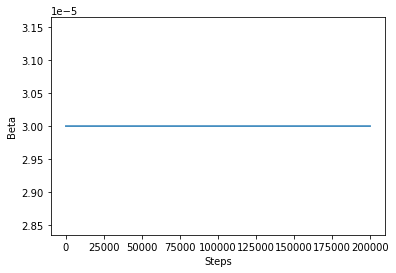

In [18]:
from lfp.train import BetaScheduler

TRAIN_STEPS = 200000
# 0.00001 so far works best for MAE - try lower - 0.00003 with a BETA accel of 10 so far works best, perfect encoder, nicely mapped planner
# recall 0.01 worked okay for probabilistic - proba still too unstable!
beta_sched = BetaScheduler('linear', 
                           beta=0.00003, 
                           beta_max=0.00003, 
                           max_steps=TRAIN_STEPS, 
                           cycles=90, 
                           duty_cycle=0.5
                           )

In [30]:
if 5 < 3: print(4)

In [32]:
def save_weights(path,actor, encoder=None, planner=None, step=""):
    os.makedirs(path, exist_ok=True)

    print('Saving model weights...')
    # Save the standardisation params
    np.savez(path + 'hyper_params', relative_obs = dataloader.relative_obs, relative_act=dataloader.relative_act, quaternion_act = dataloader.quaternion_act,
             joints=dataloader.joints, LAYER_SIZE=LAYER_SIZE, LATENT_DIM = LATENT_DIM,GRIPPER_WEIGHT = GRIPPER_WEIGHT,
             GCBC = GCBC,PROBABILISTIC = PROBABILISTIC,QUANTISED=QUANTISED, run_id = wandb.run.id, scaling=scaling, N_QUANTISATIONS=N_QUANTISATIONS)
    # save timestepped version
    if step != "": 
      actor.save_weights(path + 'model_'+str(step)+'.h5')
      if planner is not None: planner.save_weights(path + 'planner_'+str(step)+'.h5')
      if encoder is not None: encoder.save_weights(path + 'encoder_'+str(step)+'.h5')

    #save the latest version
    actor.save_weights(path + 'model.h5')
    if planner is not None: planner.save_weights(path + 'planner.h5')
    if encoder is not None: encoder.save_weights(path + 'encoder.h5')

    #save the optimizer state
    np.save(os.path.join(path, 'optimizer'), optimizer.get_weights())


def load_weights(path, actor, encoder=None, planner = None, step=""):
    actor.load_weights(f'{path}/model'+step+'.h5')
    if planner is not None: planner.load_weights(f'{path}/planner'+step+'.h5')
    if encoder is not None: encoder.load_weights(f'{path}/encoder'+step+'.h5')



def load_optimizer_state(optimizer, load_path):
    # Load optimizer weights
    opt_weights = np.load(load_path+'optimizer.npy', allow_pickle=True)

    # init the optimiser
    distributed_opt_step()
    # Set the weights of the optimizer
    optimizer.set_weights(opt_weights)


def optimizer_step():
  # need to do this to initialie the optimiser
  model_train_vars = actor.trainable_variables+encoder.trainable_variables+planner.trainable_variables
  # dummy zero gradients
  zero_grads = [tf.zeros_like(w) for w in model_train_vars]
  # save current state of variables
  saved_vars = [tf.identity(w) for w in model_train_vars]

  # Apply gradients which don't do anything
  optimizer.apply_gradients(zip(zero_grads, model_train_vars))

  # Reload variables
  [x.assign(y) for x,y in zip(model_train_vars, saved_vars)]
  return 0.0


@tf.function
def distributed_opt_step():
  '''
  Only used for optimizer checkpointing - we need to run a pass to initialise all the optimizer weights. Can't use restore as colab TPUs don't have a local filesystem. 
  '''
  per_replica_losses = strategy.run(optimizer_step, args=())
  return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)


In [33]:
progbar = Progbar(TRAIN_STEPS, verbose=1, interval=0.5)
best_valid_loss = np.float('inf')

valid_inc = 20
save_inc = 1000

prev_grad_norm = np.float('inf')

train_loss_result = []
train_act_with_enc_loss_result = []
train_act_with_plan_loss_result = []
train_reg_loss_result = []
valid_loss_result = []
valid_act_with_enc_loss_result = []
valid_act_with_plan_loss_result = []
valid_reg_loss_result = []
valid_position_loss_result = []
valid_max_position_loss_result = []
valid_rotation_loss_result = []
valid_max_rotation_loss_result = []
valid_gripper_loss_result = []
beta_result = []
latent_img_result = []



In [36]:
RESUME = True
model_path

'/content/drive/My Drive/Robotic Learning/LMP_test/Tests/'

In [37]:
run_name = "Tests"#"ALLB0.00003"
model_path = f'/content/drive/My Drive/Robotic Learning/LMP_test/{run_name}/'

if RESUME:
  run_id = str(np.load(model_path+'hyper_params.npz')['run_id'])
  wandb.init(project="learning-from-play_v2", id='12621l2h',  resume="must")
  load_weights(model_path, actor, encoder, planner)
  load_optimizer_state(optimizer, model_path)
  print('Loaded model weights and optimiser state')
  t = wandb.run.step + valid_inc
else:
  wandb.init(project="learning-from-play_v2")
  wandb.run.name = run_name
  t = 0


valid_act_with_enc_loss_result,0.00251
train_act_with_plan_loss_result,0.00267
_runtime,246875
_timestamp,1611486306
beta_result,3e-05
train_loss_result,0.00039
valid_reg_loss_result,4.08413
valid_max_rotation_loss_result,3.55939
actor_grad_norm,0.03141
encoder_grad_norm_clipped,0.0009
valid_gripper_loss_result,0.01561


Loaded model weights and optimiser state


In [38]:

config = wandb.config

# Hparams
config.DEVICE = DEVICE
config.WINDOW_SIZE = dataloader.window_size
config.WINDOW_SHIFT = dataloader.window_shift
config.LAYER_SIZE = LAYER_SIZE
config.LATENT_DIM = LATENT_DIM
config.GRIPPER_WEIGHT = GRIPPER_WEIGHT
config.TRAIN_STEPS = TRAIN_STEPS
config.beta_schedule = beta_sched.schedule
config.beta_min = beta_sched.beta_min
config.beta_max = beta_sched.beta_max
config.PROBABILISTIC = PROBABILISTIC
config.PROPRIOCEPTION = dataloader.proprioception

In [39]:
from lfp.plotting import produce_cluster_fig, project_enc_and_plan, plot_to_image
v_it = iter(valid_dataset) #for the cluster fig, easier with a non distributed dataset

In [ ]:
while t < TRAIN_STEPS:
    start_time = time.time()
    beta = beta_sched.scheduler(t)
    x = next(train_dist_dataset)
    total_train_loss = distributed_train_step(x, beta, prev_grad_norm)
    
    if t % valid_inc == 0:  
        valid_x = next(valid_dist_dataset)
        if GCBC:
          total_val_loss = distributed_test_step(valid_x, beta)
        else:
          total_val_loss, ze, zp = distributed_test_step(valid_x, beta)

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', train_loss.result()), ('Validation Loss', valid_loss.result()), ('Time (s)', round(time.time() - start_time, 1))])

        train_loss_result.append(train_loss.result())
        valid_loss_result.append(valid_loss.result())
        valid_position_loss_result.append(valid_position_loss.result())
        valid_max_position_loss_result.append(valid_max_position_loss.result())
        valid_rotation_loss_result.append(valid_rotation_loss.result())
        valid_max_rotation_loss_result.append(valid_max_rotation_loss.result())
        valid_gripper_loss_result.append(valid_gripper_loss.result())

        if GCBC:
          wandb.log({'train_loss_result':train_loss_result[-1],
                      'valid_loss_result':valid_loss_result[-1],
                      'valid_position_loss_result':valid_position_loss_result[-1],
                      'valid_max_position_loss_result':valid_max_position_loss_result[-1],
                      'valid_rotation_loss_result':valid_rotation_loss_result[-1],
                      'valid_max_rotation_loss_result':valid_max_rotation_loss_result[-1],
                      'valid_gripper_loss_result':valid_gripper_loss_result[-1],
                      'grad_norm': grad_norm.result()
                    },
                    step=t)
        else:
                    # Latent space projection
          
          train_act_with_enc_loss_result.append(train_act_with_enc_loss.result())
          train_act_with_plan_loss_result.append(train_act_with_plan_loss.result())
          train_reg_loss_result.append(train_reg_loss.result())
          valid_act_with_enc_loss_result.append(valid_act_with_enc_loss.result())
          valid_act_with_plan_loss_result.append(valid_act_with_plan_loss.result())
          valid_reg_loss_result.append(valid_reg_loss.result())
          beta_result.append(beta)

          wandb.log({'train_loss_result':train_loss_result[-1],
                      'train_act_with_enc_loss_result':train_act_with_enc_loss_result[-1],
                      'train_act_with_plan_loss_result':train_act_with_plan_loss_result[-1],
                      'train_reg_loss_result':train_reg_loss_result[-1],
                      'valid_loss_result':valid_loss_result[-1],
                      'valid_act_with_enc_loss_result':valid_act_with_enc_loss_result[-1],
                      'valid_act_with_plan_loss_result':valid_act_with_plan_loss_result[-1],
                      'valid_reg_loss_result':valid_reg_loss_result[-1],
                      'valid_position_loss_result':valid_position_loss_result[-1],
                      'valid_max_position_loss_result':valid_max_position_loss_result[-1],
                      'valid_rotation_loss_result':valid_rotation_loss_result[-1],
                      'valid_max_rotation_loss_result':valid_max_rotation_loss_result[-1],
                      'valid_gripper_loss_result':valid_gripper_loss_result[-1],
                      'beta_result':beta_result[-1],
                      'actor_grad_norm': actor_grad_norm.result(),
                     'encoder_grad_norm': encoder_grad_norm.result(),
                     'planner_grad_norm': planner_grad_norm.result(),
                     'actor_grad_norm_clipped': actor_grad_norm_clipped.result(),
                     'encoder_grad_norm_clipped': encoder_grad_norm_clipped.result(),
                     'planner_grad_norm_clipped': planner_grad_norm_clipped.result(),
                    },
                    step=t)
          

        prev_grad_norm = global_grad_norm.result()
          
        # reset metrics
        train_loss.reset_states()
        train_act_with_enc_loss.reset_states()
        train_act_with_plan_loss.reset_states()
        train_reg_loss.reset_states()
        valid_loss.reset_states()
        valid_act_with_enc_loss.reset_states()
        valid_act_with_plan_loss.reset_states()
        valid_reg_loss.reset_states()

        valid_position_loss.reset_states()
        valid_max_position_loss.reset_states()
        valid_rotation_loss.reset_states()
        valid_max_rotation_loss.reset_states()
        valid_gripper_loss.reset_states()

        actor_grad_norm.reset_states()
        encoder_grad_norm.reset_states()
        planner_grad_norm.reset_states()

        actor_grad_norm_clipped.reset_states()
        encoder_grad_norm_clipped.reset_states()
        planner_grad_norm_clipped.reset_states()

        global_grad_norm.reset_states()



    if t % save_inc == 0:
        save_weights(model_path, actor, encoder, planner)
        if not GCBC:
          z_enc, z_plan = produce_cluster_fig(next(v_it), encoder, planner, TEST_DATA_PATH, num_take=dataloader.batch_size)
          wandb.log({'z_enc':z_enc, 'z_plan':z_plan}, step=t)
          latent_fig = project_enc_and_plan(ze, zp)
          latent_img = plot_to_image(latent_fig)

    t += 1

   180/200000 [..............................] - ETA: 183:53:50 - Train Loss: 0.0103 - Validation Loss: 0.0125 - Time (s): 5.2111

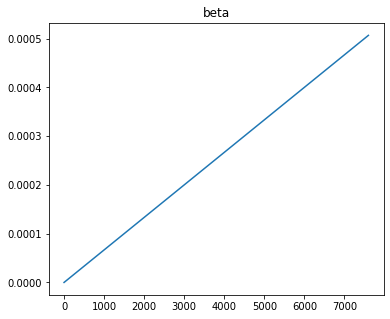

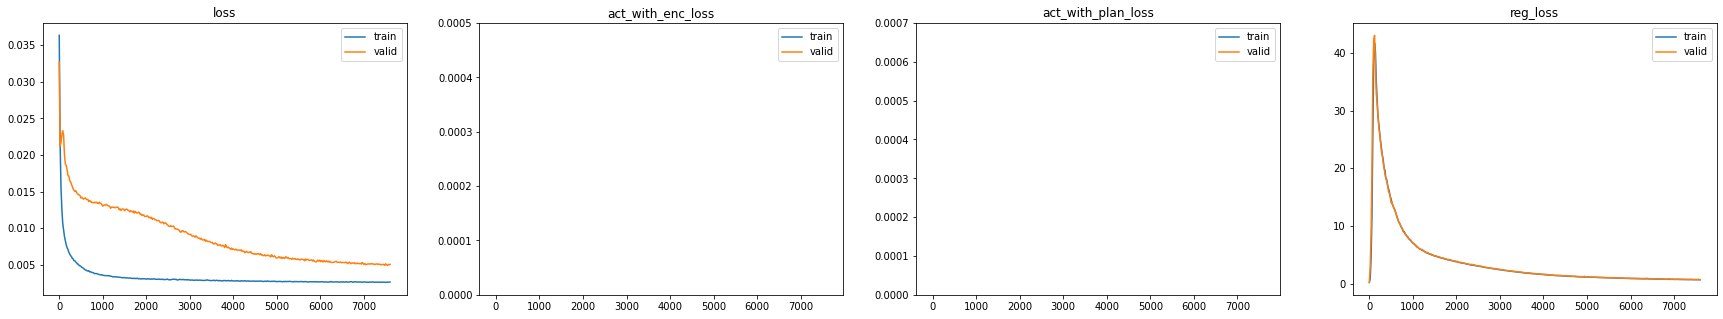

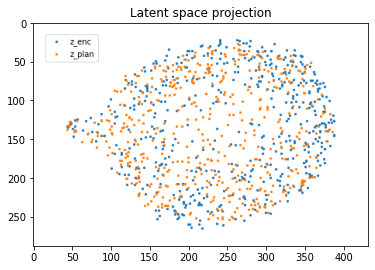

In [ ]:
#@title Broke man's Tensorboard
s = np.arange(t, step=valid_inc)

# hparams/
if not GCBC:
  f1,ax1 = plt.subplots(1,1, figsize=(6,5))
  ax1.plot(s, beta_result, label='beta')
  ax1.set_title('beta')

# losses/
f2,ax2 = plt.subplots(1,4, figsize=(30,5))
ax2[0].plot(s, train_loss_result[:-1], label='train')
ax2[0].plot(s, valid_loss_result[:-1], label='valid')
ax2[0].set_title('loss')
#ax2[0].set_ylim(0,1e-3)
if not GCBC:
  ax2[1].plot(s, train_act_with_enc_loss_result, label='train')
  ax2[1].plot(s, valid_act_with_enc_loss_result, label='valid')
  ax2[1].set_title('act_with_enc_loss')
  ax2[1].set_ylim(0,5e-4)
  ax2[2].plot(s, train_act_with_plan_loss_result, label='train')
  ax2[2].plot(s, valid_act_with_plan_loss_result, label='valid')
  ax2[2].set_title('act_with_plan_loss')
  ax2[2].set_ylim(0,7e-4)
  ax2[3].plot(s, train_reg_loss_result, label='train')
  ax2[3].plot(s, valid_reg_loss_result, label='valid')
  ax2[3].set_title('reg_loss')
  [ax.legend() for ax in ax2]
# [ax.set_yscale('log') for ax in ax2]

  # images/
  f3,ax3 = plt.subplots(1,1, figsize=(6,5))
  ax3.imshow(latent_img_result[-1].numpy()[0], label='latent_img_result')
  ax3.set_title('Latent space projection')

  plt.show()

In [ ]:

# model_name ="NB0.00001"
# model_path = f'/content/drive/My Drive/Robotic Learning/LMP_test/{model_name}/'
load_weights(model_path, actor, encoder, planner)

In [ ]:
#@title Sample a batch for timeseries plotting
# Lets plot pred actions vs true actions

batch = v_it.next()
states,acts,goals,seq_lens,masks = batch['obs'],batch['acts'],batch['goals'],batch['seq_lens'],batch['masks']
if GCBC:
  pred_acts = actor([states, goals])
else:
  encoding = encoder([states,acts])
  plan = planner([states[:, 0, :], goals[:, 0, :]]) 
                                                  
  # check if encoder is overfitting on validation
  z_enc = z = tf.tile(tf.expand_dims(encoding.sample(), 1), (1, WINDOW_SIZE, 1))
  enc_act_distrib = actor([states, z_enc, goals])

  # true validation performance, w/ planner
  z = tf.tile(tf.expand_dims(plan.sample(), 1), (1, WINDOW_SIZE, 1))
  pred_acts = actor([states, z, goals]) 

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-package

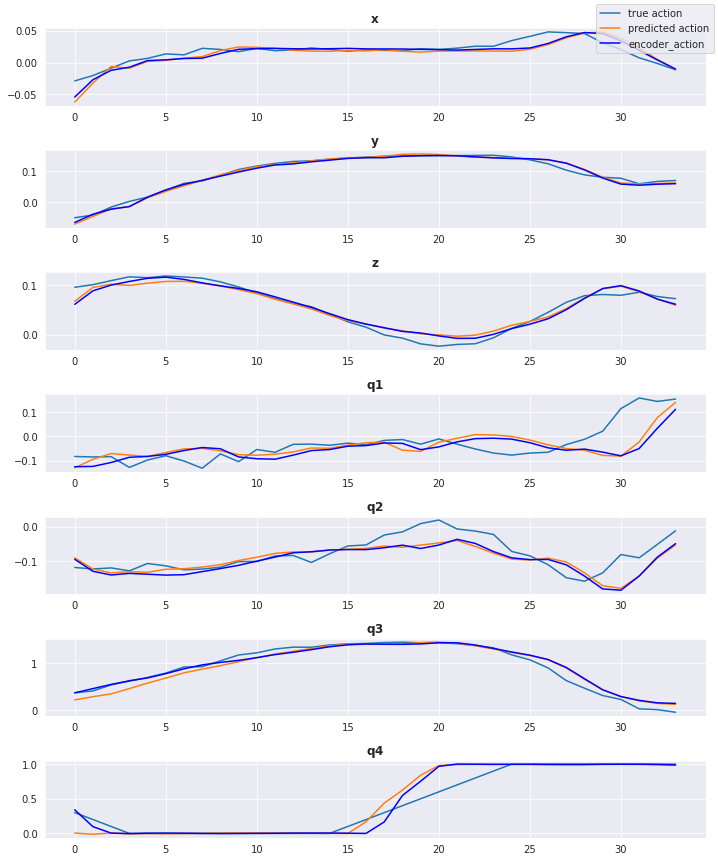

In [ ]:
#@title Plot timeseries of state/action tracking over time - xyz q1234 gripper
import seaborn as sns
sns.set_style("darkgrid")

idx = 9
seq_len = int(seq_lens[idx])
x = np.arange(seq_len)
labels = ['x','y','z','q1','q2','q3','q4','gripper']
fig, axes = plt.subplots(ACT_DIM, 1, figsize=(10,12), squeeze=True)
for i in range(ACT_DIM):
    #sns.lineplot(x, acts[idx,:seq_len,i], color='r', ax=axes[i])
    axes[i].plot(acts[idx,:seq_len,i])
    axes[i].plot(pred_acts[idx, :seq_len,i])
    #sns.lineplot(x, pred_acts[idx, :seq_len,i], color='g', ax=axes[i])
    if not GCBC:
      sns.lineplot(x, enc_act_distrib[idx, :seq_len,i], color='b', ax=axes[i])
      axes[i].set_title(f'$\\bf{labels[i]}$')
    
fig.legend( ('true action', 'predicted action', 'encoder_action'))    
plt.tight_layout()
plt.show()